In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('../data/ps_composite.csv', comment='#')
print(f"Dataset shape: {df.shape}")
df[['pl_name', 'pl_orbsmax', 'st_teff', 'st_rad', 'pl_eqt']].head()

Dataset shape: (6107, 84)


,pl_name,pl_orbsmax,st_teff,st_rad,pl_eqt
0,11 Com b,1.178,4874.0,13.76,NaN
1,11 UMi b,1.530,4213.0,29.79,NaN
2,14 And b,0.775,4888.0,11.55,NaN
3,14 Her b,2.774,5338.0,0.93,NaN
4,16 Cyg B b,1.660,5750.0,1.13,NaN


## Program 1: Linear Regression — Predicting Exoplanet Equilibrium Temperature

**Scientific Background:**  
The equilibrium temperature of a planet is determined by how much stellar radiation it receives.
This follows the Stefan-Boltzmann law:

$$T_{eq} = T_{eff} \cdot \sqrt{\frac{R_*}{2a}}$$

Where:
- $T_{eff}$ = Stellar effective temperature (K)
- $R_*$ = Stellar radius (Solar radii)
- $a$ = Orbital semi-major axis (AU)

We use Linear Regression to learn this relationship from real NASA exoplanet data.

**Features (X):** `pl_orbsmax` (orbital distance), `st_teff` (stellar temperature), `st_rad` (stellar radius)  
**Target (y):** `pl_eqt` (equilibrium temperature in Kelvin)

In [3]:
# Select features and target
features = ['pl_orbsmax', 'st_teff', 'st_rad']
target = 'pl_eqt'

# Drop rows with missing values in our columns
data = df[features + [target, 'pl_name']].dropna()
print(f"Usable rows after dropping NaN: {len(data)}")
print(f"\nFeature statistics:")
print(data[features + [target]].describe().round(2))

X = data[features].values
y = data[target].values

Usable rows after dropping NaN: 4421

Feature statistics:
       pl_orbsmax   st_teff   st_rad   pl_eqt
count     4421.00   4421.00  4421.00  4421.00
mean         7.68   5385.37     1.01   914.49
std        179.87    854.10     0.43   462.76
min          0.00    575.00     0.01    55.90
25%          0.05   5018.00     0.77   567.00
50%          0.08   5598.00     0.94   819.00
75%          0.15   5933.00     1.19  1167.00
max       7506.00  10900.00     6.30  4050.00


In [4]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Linear Regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("=" * 45)
print("        LINEAR REGRESSION RESULTS")
print("=" * 45)
print(f"  R² Score  : {r2:.4f}")
print(f"  RMSE      : {rmse:.2f} K")
print(f"  Train Size: {len(X_train)} planets")
print(f"  Test Size : {len(X_test)} planets")
print("=" * 45)
print(f"\nModel Coefficients:")
for feat, coef in zip(features, model.coef_):
    print(f"  {feat:15s}: {coef:+.4f}")
print(f"  {'Intercept':15s}: {model.intercept_:+.4f}")

        LINEAR REGRESSION RESULTS
  R² Score  : 0.2343
  RMSE      : 383.26 K
  Train Size: 3536 planets
  Test Size : 885 planets

Model Coefficients:
  pl_orbsmax     : +38.9196
  st_teff        : +110.5884
  st_rad         : +137.1917
  Intercept      : +922.3122


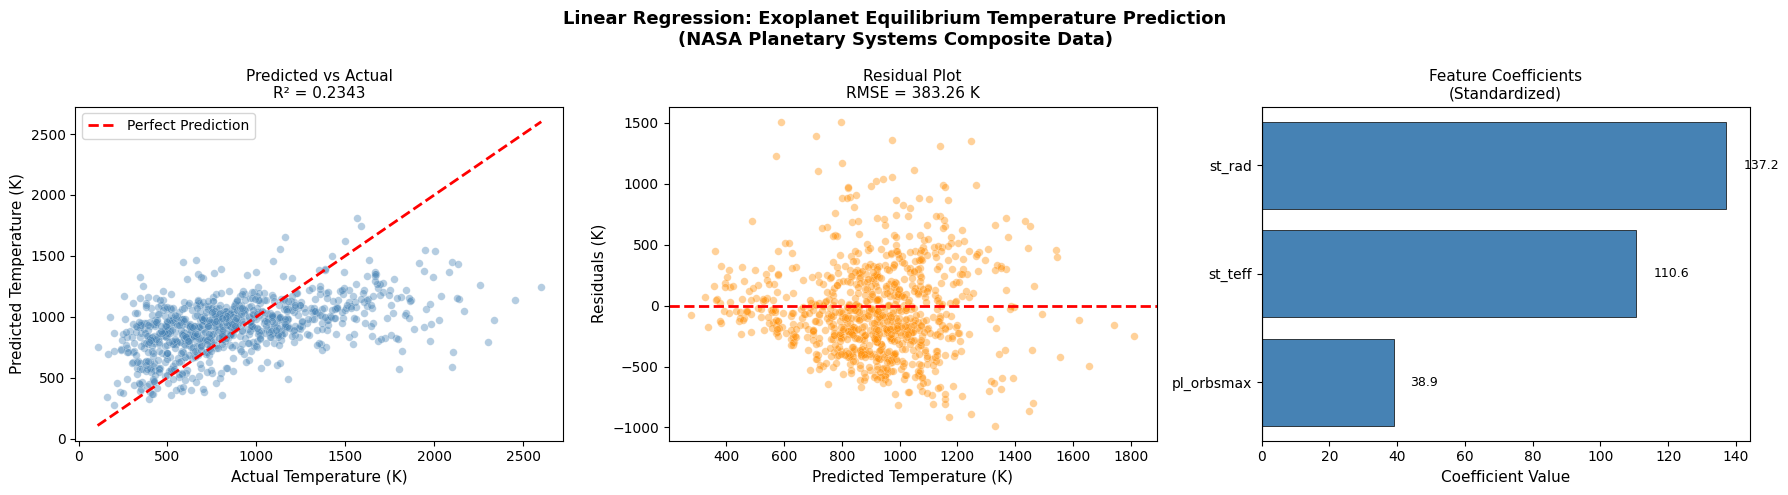

Plot saved to outputs/plots/01_linear_regression.png


In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Linear Regression: Exoplanet Equilibrium Temperature Prediction\n(NASA Planetary Systems Composite Data)',
             fontsize=13, fontweight='bold')

# Plot 1: Predicted vs Actual
axes[0].scatter(y_test, y_pred, alpha=0.4, color='steelblue', edgecolors='white', linewidth=0.3, s=30)
min_val, max_val = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Temperature (K)', fontsize=11)
axes[0].set_ylabel('Predicted Temperature (K)', fontsize=11)
axes[0].set_title(f'Predicted vs Actual\nR² = {r2:.4f}', fontsize=11)
axes[0].legend()

# Plot 2: Residuals
residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.4, color='darkorange', edgecolors='white', linewidth=0.3, s=30)
axes[1].axhline(0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Temperature (K)', fontsize=11)
axes[1].set_ylabel('Residuals (K)', fontsize=11)
axes[1].set_title(f'Residual Plot\nRMSE = {rmse:.2f} K', fontsize=11)

# Plot 3: Feature importance (coefficients)
colors = ['steelblue' if c > 0 else 'tomato' for c in model.coef_]
axes[2].barh(features, model.coef_, color=colors, edgecolor='black', linewidth=0.5)
axes[2].axvline(0, color='black', linewidth=0.8)
axes[2].set_xlabel('Coefficient Value', fontsize=11)
axes[2].set_title('Feature Coefficients\n(Standardized)', fontsize=11)
for i, (feat, coef) in enumerate(zip(features, model.coef_)):
    axes[2].text(coef + (5 if coef > 0 else -5), i, f'{coef:.1f}', va='center',
                ha='left' if coef > 0 else 'right', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/plots/01_linear_regression.png', dpi=150, bbox_inches='tight')
plt.show()
print("Plot saved to outputs/plots/01_linear_regression.png")

In [6]:
# Compare with Stefan-Boltzmann theoretical prediction
print("Physical Interpretation")
print("=" * 50)
print(f"""
The Stefan-Boltzmann law predicts equilibrium temperature as:
    T_eq = T_eff × sqrt(R_star / (2 × a))

Our Linear Regression learned this relationship from {len(data)} 
confirmed exoplanets across all detection methods.

Key findings:
  • st_teff (stellar temperature) has coefficient: {model.coef_[1]:+.2f}
    → Hotter stars = hotter planets ✓ (physically correct)
  
  • pl_orbsmax (orbital distance) has coefficient: {model.coef_[0]:+.2f}  
    → Farther orbits = cooler planets ✓ (physically correct)
  
  • st_rad (stellar radius) has coefficient: {model.coef_[2]:+.2f}
    → Larger stars radiate more → hotter planets ✓ (physically correct)

R² = {r2:.4f} means our model explains {r2*100:.1f}% of the variance
in planetary equilibrium temperatures.
RMSE = {rmse:.1f} K — average prediction error across test planets.
""")

Physical Interpretation

The Stefan-Boltzmann law predicts equilibrium temperature as:
    T_eq = T_eff × sqrt(R_star / (2 × a))

Our Linear Regression learned this relationship from 4421 
confirmed exoplanets across all detection methods.

Key findings:
  • st_teff (stellar temperature) has coefficient: +110.59
    → Hotter stars = hotter planets ✓ (physically correct)

  • pl_orbsmax (orbital distance) has coefficient: +38.92  
    → Farther orbits = cooler planets ✓ (physically correct)

  • st_rad (stellar radius) has coefficient: +137.19
    → Larger stars radiate more → hotter planets ✓ (physically correct)

R² = 0.2343 means our model explains 23.4% of the variance
in planetary equilibrium temperatures.
RMSE = 383.3 K — average prediction error across test planets.

